In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24

@author: yaning
"""

import HH as HH
import importlib
import numpy as np
import matplotlib.pyplot as plt

importlib.reload(HH)

<module 'HH' from '/home/yaning/Documents/Spiking_NN/HH.py'>

In [49]:
# simulation environment
deltaTms = 0.05
Cm = 1
# other Vm initialisation can lead to random firing
Vm = 1.3458754117369027
# 5000 cycles and every cycle is 0.01ms
# in total 50ms
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * deltaTms #record the actual time
stim = np.zeros(pointCount)
# no injection current because the ampa current will be the injection current
stim[1500:4000] = 0  # create a square pulse
mg = 7

# excitatory presynapse firing
first_pre_firing = list(range(500, 521)) 
second_pre_firing = list(range(1500, 1750))
third_pre_firing = list(range(2500, 2750))
tsp_pre = first_pre_firing + second_pre_firing

first_inhibi_pre_firing = list(range(1000, 1100))
# 200 steps more can cause action potential afterwards
second_inhibi_pre_firing = list(range(3000, 3050))
tsp_pre_inhibi = first_inhibi_pre_firing + second_inhibi_pre_firing
tsp_pre_inhibi = []

In [50]:
sodium_channel = HH.Voltage_Sodium(Vm)
potassium_channel = HH.Voltage_Potassium(Vm)
leaky_channel = HH.Voltage_Leak(Vm)

# because I am using factory, so the initialised values stay the same
# even the below line runs again
ampa_receptor = HH.LigandGatedChannelFactory.create_AMPA(Vm)
nmda_receptor = HH.LigandGatedChannelFactory.create_NMDA(Vm)

gaba_receptor = HH.LigandGatedChannelFactory.create_GABA(Vm)

na_currents = []
k_currents = []
leak_currents = []
ampa_currents = []
nmda_currents = []
gaba_currents = []

na_gps = []
ampa_gps = []
nmda_gps = []
gaba_gps = []

for i in range(len(times)):

    sodium_channel.update_gP(deltaTms)
    potassium_channel.update_gP(deltaTms)

    ampa_receptor.update_gP(i, deltaTms, tsp_pre)
    nmda_receptor.update_gP(i, deltaTms, tsp_pre, mg)
    gaba_receptor.update_gP(i, deltaTms, tsp_pre_inhibi)

    ampa_gps.append(ampa_receptor.gP)
    na_gps.append(sodium_channel.gP)
    nmda_gps.append(nmda_receptor.gP)
    gaba_gps.append(gaba_receptor.gP)


    try:
        # get the currents
        INa = sodium_channel.current()
        IK = potassium_channel.current()
        Ileak = leaky_channel.current()

        Iampa = ampa_receptor.current()
        Inmda = nmda_receptor.current()
        Igaba = gaba_receptor.current()


        currents = {
            "INa": INa,
            "IK": IK,
            "Ileak": Ileak,
            "Iampa": Iampa,
            "Inmda": Inmda,
            "Igaba": Igaba
        }
        # check for over or underflow
        
        for name, current in currents.items():
            if current > 1e10:
                raise OverflowError(f"Overflowed: {name} = {current} at {i} time point")
        
    except OverflowError as m:
        print(f"error: {m}")
        break

    threshold = 1e-10  # Define your underflow threshold

    # Replace underflowing currents with 0
    INa = INa if abs(INa) >= threshold else 0
    IK = IK if abs(IK) >= threshold else 0
    Ileak = Ileak if abs(Ileak) >= threshold else 0
    Iampa = Iampa if abs(Iampa) >= threshold else 0
    Inmda = Inmda if abs(Inmda) >= threshold else 0
    Igaba = Igaba if abs(Igaba) >= threshold else 0


    na_currents.append(INa)
    k_currents.append(IK)
    leak_currents.append(Ileak)
    ampa_currents.append(Iampa)
    nmda_currents.append(Inmda)
    gaba_currents.append(Igaba)


    # sum the currents
    Isum = stim[i] - INa - IK - Ileak - Igaba - Iampa - Inmda

    Vm += deltaTms * Isum / Cm

    voltages[i] = Vm

    # update the voltages for each channel
    sodium_channel.Vm = Vm
    potassium_channel.Vm = Vm
    leaky_channel.Vm = Vm

    ampa_receptor.Vm = Vm
    nmda_receptor.Vm = Vm
    gaba_receptor.Vm = Vm

    # when post synaptic fires weight updates
    #!!!!!!!!!!this part is wrong because sometimes it does not fire but the shape is still this
    if i >= 2:
        if voltages[i-2] <= voltages[i-1] and voltages[i-1] >= voltages[i]:
            # ampa_receptor.update_w(i)
            # nmda_receptor.update_w(i)
            # gaba_receptor.update_w(i)
            print(f"this is activated at {i}")


this is activated at 238
this is activated at 561
this is activated at 885
this is activated at 1219
this is activated at 1627
this is activated at 2026
this is activated at 2351
this is activated at 2679
this is activated at 3027
this is activated at 4307
this is activated at 4722
this is activated at 4747
this is activated at 4802
this is activated at 4913
this is activated at 4916
this is activated at 4919
this is activated at 4922
this is activated at 4925
this is activated at 4928
this is activated at 4931
this is activated at 4934
this is activated at 4937
this is activated at 4940
this is activated at 4943
this is activated at 4946
this is activated at 4949
this is activated at 4952
this is activated at 4955
this is activated at 4958
this is activated at 4961
this is activated at 4964
this is activated at 4967
this is activated at 4970
this is activated at 4973
this is activated at 4976
this is activated at 4979
this is activated at 4982
this is activated at 4985
this is activat

In [51]:
HH.LigandGatedChannelFactory.gMax_AMPA
# nmda_receptor.w

0.0072

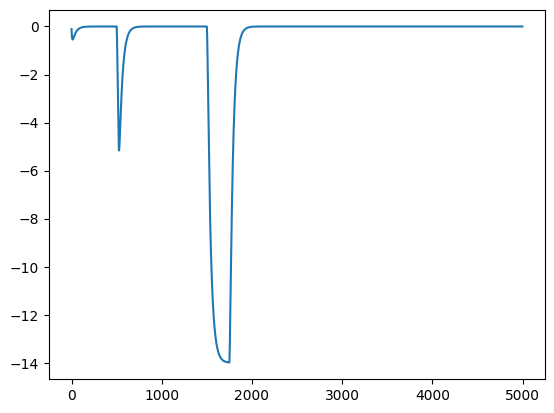

In [52]:
plt.plot(ampa_gps , label="na")
# plt.xlim(1490,1760)
# plt.plot(ampa_gps , label="ampa")
# plt.plot(nmda_gps , label="nmda")

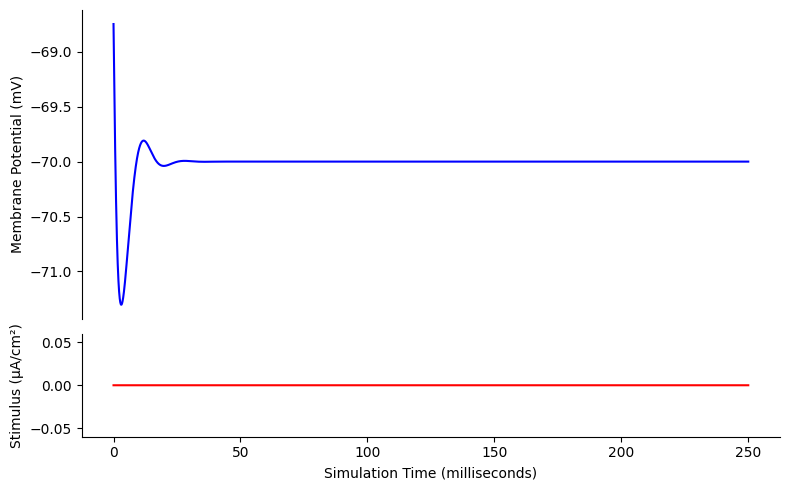

In [53]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
# plt.savefig("dev/concept4.png")
plt.show()

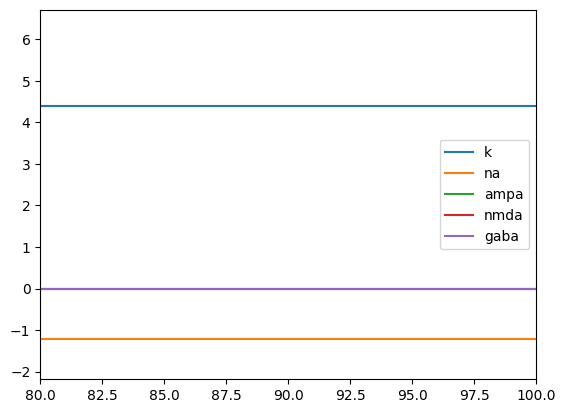

In [54]:
# plt.plot(times, leak_currents, label="leaky")
plt.plot(times, k_currents, label="k")
plt.plot(times, na_currents, label="na")
plt.plot(times, ampa_currents, label="ampa")
plt.plot(times, nmda_currents, label="nmda")
plt.plot(times, gaba_currents, label="gaba")

plt.xlim(80, 100)
plt.legend()

In [55]:
min(ampa_currents)

-0.002717520267677528